# Residual Gaussian process (ResGP) 教程
作者：Zhenjie Lu<br />
日期: 2024-6-27<br />
摘要：2020 年 Xing, Wei W 等人提出残差高斯过程模型（Residual Gaussian process, ResGP）模型，最高精度GP模型写为最低精度GP和各精度GP模型解和解之间的残差项之和的形式, 该方法预测后验的解是闭环解，可以用于复杂的高维数据预测及不确定性估计，同时也降低了训练成本。在代码构建上，它和传统的AR多精度模型有很大的相似性。

首先，让我们来导入一些最基础的模块；由于仓库构造的特殊性，需要将工作目录设置到上一层，再导入相应的依赖模块

In [10]:
import sys
import os

# 将上级目录添加到Python路径中
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

和 AR 相同, ResGP的底层也是高斯过程(GP),因此我们需要导入 GP 模块

In [11]:
import torch
import torch.nn as nn
import GaussianProcess.kernel as kernel
from GaussianProcess.cigp_v10 import cigp as GPR

## 1.模型定义
ResGP的表达式可以表示为</br>
$y^f (ξ)=∑_{k=1}^fr^k (ξ)(f=1,2,…,F)$</br>
$r^f (ξ)= y^f (ξ)- y^{f-1}(ξ)   (f=2,3,…,F)$</br>
第𝑓精度的模型𝑓(𝜉)可以看作之前精度的残差项模型的累加，其中残差项$r^f (ξ)$是邻近的两个精度GP解之差

In [12]:
class ResGP_demo(nn.Module):
    """
    Residual Gaussian Process model.

    Args:
        fidelity_num (int): Number of fidelity levels.
        kernel_list (list): List of kernels for each fidelity level.
        if_nonsubset (bool, optional): Flag indicating if non-subset data is used. Defaults to False.
    """

    def __init__(self, fidelity_num, kernel_list, if_nonsubset=False):
        super().__init__()
        self.fidelity_num = fidelity_num
        self.gpr_list = []
        for i in range(self.fidelity_num):
            self.gpr_list.append(GPR(kernel=kernel_list[i], log_beta=1.0))
        self.gpr_list = torch.nn.ModuleList(self.gpr_list)
        self.if_nonsubset = if_nonsubset

## 2.前向过程
ResGP 的前向过程是指从低精度到高精度的过程，即从低精度数据的高斯过程回归模型和一个残差高斯过程回归组成高精度数据的高斯过程回归; 而贝叶斯方法需要使用先验数据的分布去预测后验，所以在前向过程中，需要使用到训练的数据，在数据管理上，为了避免模型的体量过大，采用特定的数据管理类对数据进行管理。</br>
数据被分成子集数据以及非子集数据(高精度的数据的输入部分不是低精度数据的一部分),在处理这种数据的时候，需要进行虚子集部分预测，因此还需要添加一个让模型预测到相应精度的指示位(to_fidelity),模型的前向定义如下：

In [13]:
def forward_demo(self, data_manager, x_test, to_fidelity=None):
    """
    Forward pass of the ResGP model.

    Args:
        data_manager (DataManager): Data manager object.
        x_test (torch.Tensor): Test input data.
        to_fidelity (int, optional): Fidelity level to predict. Defaults to None.

    Returns:
        torch.Tensor: Predicted output.
        torch.Tensor: Covariance of the predictions.
    """
    if to_fidelity is not None:
        fidelity_level = to_fidelity
    else:
        fidelity_level = self.fidelity_num - 1
    for i_fidelity in range(fidelity_level + 1):
        if i_fidelity == 0:
            x_train, y_train = data_manager.get_data(i_fidelity, normal=True)
            y_pred_low, cov_pred_low = self.gpr_list[i_fidelity](x_train, y_train, x_test)
            if fidelity_level == 0:
                y_pred_high = y_pred_low
                cov_pred_high = cov_pred_low
        else:
            x_train, y_train = data_manager.get_data_by_name('res-{}'.format(i_fidelity))
            y_pred_res, cov_pred_res = self.gpr_list[i_fidelity](x_train, y_train, x_test)
            y_pred_high = y_pred_low + y_pred_res
            cov_pred_high = cov_pred_low + cov_pred_res

            # for next fidelity
            y_pred_low = y_pred_high
            cov_pred_low = cov_pred_high

    return y_pred_high, cov_pred_high

## 3.数据准备
为了验证模型,我们需要构建一些多精度的数据，这里我们基于正弦函数构造三精度的实验数据,并将实验数据储存到数据管理类中

In [14]:
torch.manual_seed(1)
from FidelityFusion_Models.MF_data import MultiFidelityDataManager
# generate the data
x_all = torch.rand(500, 1) * 20
xlow_indices = torch.randperm(500)[:300]
xlow_indices = torch.sort(xlow_indices).values
x_low = x_all[xlow_indices]
xhigh1_indices = torch.randperm(500)[:300]
xhigh1_indices = torch.sort(xhigh1_indices).values
x_high1 = x_all[xhigh1_indices]
xhigh2_indices = torch.randperm(500)[:250]
xhigh2_indices = torch.sort(xhigh2_indices).values
x_high2 = x_all[xhigh2_indices]
x_test = torch.linspace(0, 20, 100).reshape(-1, 1)

y_low = torch.sin(x_low) - 0.5 * torch.sin(2 * x_low) + torch.rand(300, 1) * 0.1 - 0.05
y_high1 = torch.sin(x_high1) - 0.3 * torch.sin(2 * x_high1) + torch.rand(300, 1) * 0.1 - 0.05
y_high2 = torch.sin(x_high2) + torch.rand(250, 1) * 0.1 - 0.05
y_test = torch.sin(x_test)

initial_data = [
    {'raw_fidelity_name': '0','fidelity_indicator': 0, 'X': x_low, 'Y': y_low},
    {'raw_fidelity_name': '1','fidelity_indicator': 1, 'X': x_high1, 'Y': y_high1},
    {'raw_fidelity_name': '2','fidelity_indicator': 2, 'X': x_high2, 'Y': y_high2},
]
fidelity_num = len(initial_data)

fidelity_manager = MultiFidelityDataManager(initial_data)

## 4.封装实例化模型
以下我们将ResGP模型的定义以及前向传播封装成一个类,并进行实例化

In [15]:
class ResGP(nn.Module):
    """
    Residual Gaussian Process model.

    Args:
        fidelity_num (int): Number of fidelity levels.
        kernel_list (list): List of kernels for each fidelity level.
        if_nonsubset (bool, optional): Flag indicating if non-subset data is used. Defaults to False.
    """

    def __init__(self, fidelity_num, kernel_list, if_nonsubset=False):
        super().__init__()
        self.fidelity_num = fidelity_num
        self.gpr_list = []
        for i in range(self.fidelity_num):
            self.gpr_list.append(GPR(kernel=kernel_list[i], log_beta=1.0))
        self.gpr_list = torch.nn.ModuleList(self.gpr_list)
        self.if_nonsubset = if_nonsubset

    def forward(self, data_manager, x_test, to_fidelity=None):
        """
        Forward pass of the ResGP model.

        Args:
            data_manager (DataManager): Data manager object.
            x_test (torch.Tensor): Test input data.
            to_fidelity (int, optional): Fidelity level to predict. Defaults to None.

        Returns:
            torch.Tensor: Predicted output.
            torch.Tensor: Covariance of the predictions.
        """
        if to_fidelity is not None:
            fidelity_level = to_fidelity
        else:
            fidelity_level = self.fidelity_num - 1
        for i_fidelity in range(fidelity_level + 1):
            if i_fidelity == 0:
                x_train, y_train = data_manager.get_data(i_fidelity, normal=True)
                y_pred_low, cov_pred_low = self.gpr_list[i_fidelity](x_train, y_train, x_test)
                if fidelity_level == 0:
                    y_pred_high = y_pred_low
                    cov_pred_high = cov_pred_low
            else:
                x_train, y_train = data_manager.get_data_by_name('res-{}'.format(i_fidelity))
                y_pred_res, cov_pred_res = self.gpr_list[i_fidelity](x_train, y_train, x_test)
                y_pred_high = y_pred_low + y_pred_res
                cov_pred_high = cov_pred_low + cov_pred_res

                # for next fidelity
                y_pred_low = y_pred_high
                cov_pred_low = cov_pred_high

        return y_pred_high, cov_pred_high

kernel_list = [kernel.SquaredExponentialKernel() for _ in range(fidelity_num)]
myResGP = ResGP(fidelity_num = fidelity_num,kernel_list=kernel_list, if_nonsubset = True)

## 5.模型训练
接下来我们定义模型的训练过程，并对模型进行训练。可以通过训练第$t - 1$个精度的高斯模型$y^{𝑡−1}(𝑥)$和残差高斯模型$r^𝑡(𝑥)$，搭建从第$𝑡 − 1$个精度到第𝑡个精度的等式，使用低精度数据对高一精度的数据进行预测, 训练时，从最低精度高斯模型$y^1(𝑥)$依次向上叠加，直至最高精度$y^f(𝑥)$，训练出各个精度的全部参数。预测时，将输入值$𝑥_f$带入最低精度模型$y^1(𝑥)$，预测出最低精度的输出，再依次向上迭代，直到最高精度数据的预测

In [16]:
def train_ResGP(ResGPmodel, data_manager, max_iter=1000, lr_init=1e-1):
    """
    Trains the Residual Gaussian Process (ResGP) model.

    Args:
        ResGPmodel (ResGPModel): The ResGP model to train.
        data_manager (DataManager): The data manager object.
        max_iter (int, optional): The maximum number of iterations for training. Defaults to 1000.
        lr_init (float, optional): The initial learning rate for the optimizer. Defaults to 1e-1.
        debugger (Debugger, optional): The debugger object for monitoring training progress. Defaults to None.
    """
    for i_fidelity in range(ResGPmodel.fidelity_num):
        optimizer = torch.optim.Adam(ResGPmodel.parameters(), lr=lr_init)
        if i_fidelity == 0:
            x_low, y_low = data_manager.get_data(i_fidelity, normal=True)
            for i in range(max_iter):
                optimizer.zero_grad()
                loss = ResGPmodel.gpr_list[i_fidelity].negative_log_likelihood(x_low, y_low)
                loss.backward()
                optimizer.step()
                # print('fidelity:', i_fidelity, 'iter', i, 'nll:{:.5f}'.format(loss.item()))
                print('fidelity {}, epoch {}/{}, nll: {}'.format(i_fidelity, i+1, max_iter, loss.item()), end='\r')
            print('')
        else:
            if ResGPmodel.if_nonsubset:
                with torch.no_grad():
                    subset_x, y_low, y_high = data_manager.get_nonsubset_fill_data(ResGPmodel, i_fidelity - 1, i_fidelity)
                y_residual_mean = y_high[0] - y_low[0]
                y_residual_var = abs(y_high[1] - y_low[1])
            else:
                _, y_low, subset_x, y_high = data_manager.get_overlap_input_data(i_fidelity - 1, i_fidelity, normal=True)
                y_residual_mean = y_high - y_low
                y_residual_var = None
            if y_residual_var is not None:
                y_residual_var = y_residual_var.detach()
            data_manager.add_data(raw_fidelity_name='res-{}'.format(i_fidelity), fidelity_index=None, x=subset_x.detach(), y=[y_residual_mean.detach(), y_residual_var])
            for i in range(max_iter):
                optimizer.zero_grad()
                loss = ResGPmodel.gpr_list[i_fidelity].negative_log_likelihood(subset_x, [y_residual_mean, y_residual_var])
                loss.backward()
                optimizer.step()
                # print('fidelity:', i_fidelity, 'iter', i, 'nll:{:.5f}'.format(loss.item()))
                print('fidelity {}, epoch {}/{}, nll: {}'.format(i_fidelity, i+1, max_iter, loss.item()), end='\r')
            print('')
train_ResGP(myResGP, fidelity_manager, max_iter=200, lr_init=1e-2)

fidelity 0, epoch 200/200, nll: 237.97351074218752
fidelity 1, epoch 200/200, nll: 94.379486083984385
fidelity 2, epoch 200/200, nll: 126.55236816406258


## 6.模型预测
在模型训练完成后，我们可以使用模型进行预测，这里我们使用训练数据进行预测，预测的结果与真实值进行对比,并进行可视化展示

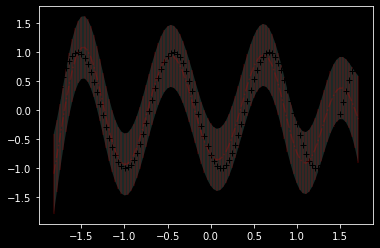

In [17]:
import matplotlib.pyplot as plt
with torch.no_grad():
    x_test = fidelity_manager.normalizelayer[myResGP.fidelity_num-1].normalize_x(x_test)
    ypred, ypred_var = myResGP(fidelity_manager, x_test)
    ypred, ypred_var = fidelity_manager.normalizelayer[myResGP.fidelity_num-1].denormalize(ypred, ypred_var)
        
plt.figure()
plt.errorbar(x_test.flatten(), ypred.reshape(-1).detach(), ypred_var.diag().sqrt().squeeze().detach(), fmt = 'r-.' ,alpha = 0.2)
plt.fill_between(x_test.flatten(), ypred.reshape(-1).detach() - ypred_var.diag().sqrt().squeeze().detach(), ypred.reshape(-1).detach() + ypred_var.diag().sqrt().squeeze().detach(), alpha = 0.2)
plt.plot(x_test.flatten(), y_test, 'k+')
plt.show()